In [1]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# Fix for notebooks: add the parent directory to sys.path
notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))

# Now import your custom robot class
from classrobot.UR5e_DH import UR5eDH
import roboticstoolbox as rtb


In [2]:
def moveL_custom_cubic(robot, T_start, T_goal, q_start, duration=3.0, frequency=100, plot_graph=True):
    """
    Cartesian linear trajectory using cubic time scaling and inverse Jacobian control.
    Optionally plots joint positions or EE path after motion.
    """
    dt = 1.0 / frequency
    steps = int(duration * frequency)
    q = np.array(q_start)

    # For graph plotting
    s_list = []
    t_list = []
    ee_path = []
    joint_path = []

    for step in range(steps + 1):
        t = step * dt
        tau = t / duration

        # Cubic time-scaling
        s = 3 * tau**2 - 2 * tau**3

        # Interpolate desired pose
        T_desired = T_start.interp(T_goal, s)

        # Get twist (velocity)
        T_current = robot.fkine(q)
        delta_twist = (T_current.inv() @ T_desired).twist()

        # Jacobian-based joint velocity
        J = robot.jacob0(q)
        q_dot = np.linalg.pinv(J) @ delta_twist

        # Integrate
        q = q + q_dot * dt

        # Log for plotting
        s_list.append(s)
        t_list.append(t)
        ee_path.append(T_current.t)  # end-effector position
        joint_path.append(q.copy())

        time.sleep(dt)

    if plot_graph:
        ee_path = np.array(ee_path)
        joint_path = np.array(joint_path)

        fig, axs = plt.subplots(2, 1, figsize=(10, 6))

        # End-effector path
        axs[0].plot(t_list, ee_path[:, 0], label='x')
        axs[0].plot(t_list, ee_path[:, 1], label='y')
        axs[0].plot(t_list, ee_path[:, 2], label='z')
        axs[0].set_title('End-Effector Position Over Time')
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('Position [m]')
        axs[0].legend()
        axs[0].grid(True)

        # Scalar interpolation plot
        axs[1].plot(t_list, s_list, color='purple')
        axs[1].set_title('Cubic Interpolation s(t)')
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('s (0 to 1)')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    return q

In [ ]:
robot = UR5eDH()
tool_offset = SE3(0, 0, 0.2)
robot.tool = tool_offset
q
RPY = [-1.7224438319206319, 0.13545161633255984, -1.2975236351897372]
pos = [0.8416483261808753, 0.18340553760528544, 0.02899994373321535] + RPY
T_inv = robot.ik_LM(pos)
# print(T_inv)
# convert to deg
T_inv_deg = np.rad2deg(T_inv[0])  # Extract the first element of the tuple and convert to degrees
print(T_inv_deg)


[-172.02368236 -153.62102115 -146.66646321  -39.82116153  -65.81560717
  155.62059389]


In [ ]:
robot.plot()

In [5]:
jaoco = robot.jacob0(q, T)
print(jaoco)

[[-8.43834168e-02 -7.38623101e-03  3.35622790e-01  8.65588639e-02
   1.32734950e-02  0.00000000e+00]
 [ 7.99610817e-01 -3.19420749e-03  1.45141524e-01  3.74327544e-02
  -2.99298818e-01  0.00000000e+00]
 [ 8.20424958e-17  7.67416710e-01  5.65015321e-01  2.81842543e-01
  -2.04737386e-03  0.00000000e+00]
 [ 1.23408894e-16  3.96928073e-01  3.96928073e-01  3.96928073e-01
   1.76222798e-02  9.98862656e-01]
 [ 5.02148882e-17 -9.17849718e-01 -9.17849718e-01 -9.17849718e-01
   7.62083099e-03  4.41754636e-02]
 [ 1.00000000e+00 -1.74699176e-19 -1.74699176e-19 -1.74699176e-19
  -9.99815672e-01  1.79421982e-02]]


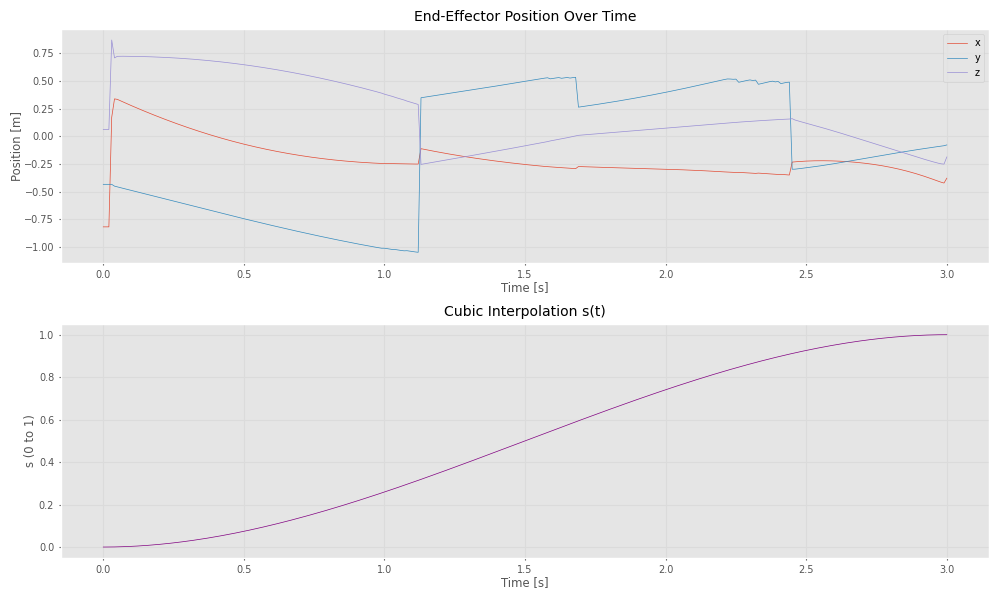

In [6]:

q_start = robot.q
T_start = robot.fkine(q_start)
T_goal = SE3(0.4, 0.2, 0.3) @ SE3.OA([1, 0, 0], [0, 0, -1])

final_q = moveL_custom_cubic(
    robot,
    T_start,
    T_goal,
    q_start,
    duration=3.0,
    frequency=100,
    plot_graph=True
)
